In [1]:
import masp as srs
import numpy as np
import soundfile as sf
from IPython.display import Audio
import scipy.signal as sig
import copy
import pandas as pd
import os
from os.path import join as pjoin
from multiprocessing import Pool
import matplotlib.pyplot as plt
import mat73
import pyrubberband as pyrb
import helpers as hlp
import importlib
importlib.reload(hlp);
import tqdm

In [2]:
#a = df.iloc[i]
def process(a, correct):
    mic = np.array(hlp.head_2_ku_ears(np.array([a.headC_x, a.headC_y, a.headC_z]),
                                            np.array([a.headOrient_azi,a.headOrient_ele])))
    # load noise:
    noise, _ = sf.read(pjoin(pjoin(pjoin(wham_path, 'wham_noise'), a.wham_split), a.noise_path))

    # time stretch if needed
    if a.stretch != 0.0:
        noise = pyrb.time_stretch(noise, a.fs_noise, a.stretch)

    # extend if needed with hanning window
    noise = np.array([hlp.extend_noise(noise[:,0], a.num_chunks * 4 * a.fs_noise, a.fs_noise),
            hlp.extend_noise(noise[:,1], a.num_chunks * 4 * a.fs_noise, a.fs_noise)]).T
    # crop 4 seconds chunk
    noise = noise[a.chunk * 4 * a.fs_noise :(a.chunk + 1) * 4 * a.fs_noise]

    # invert phase for augmentation
    if a.phase_inv:
        noise *= -1

    # invert channels for augmentation
    if a.lr_inv:
        noise = noise[:, [1,0]]

    noise = noise.T

    # load speech and crop at the 4s chunk that has more energy
    speech_folder = pjoin(pjoin(mls_path, a.mls_split), 'audio')
    speech, _ = sf.read(pjoin(pjoin(pjoin(speech_folder, str(a.speaker)), str(a.book)), a.speech_path))
    env = sig.fftconvolve(speech, np.ones(4*a.fs_noise), 'same')
    idx_candidates = np.flip(np.argsort(env**2))
    idx = idx_candidates[idx_candidates < (len(speech)-(4*a.fs_noise))][0]
    speech = speech[idx:idx+4*a.fs_noise]

    room = np.array([a.room_x, a.room_y, a.room_z])
    rt60 = np.array([a.rt60])
    rt60 *= 0.5 #furniture absorption 
    #snr 0, more people, more reduction -> 0.3 * rt60
    #snr 5, less people, no rt60 reduction -> 1.0 * rt60
    rt60 *= ((a.snr+0.3)/5.3) # people absoprtion
    src = np.array([[a.src_x, a.src_y, a.src_z]])
    head_orient = np.array([a.headOrient_azi, a.headOrient_ele])

    # Compute absorption coefficients for desired rt60 and room dimensions
    abs_walls,rt60_true = srs.find_abs_coeffs_from_rt(room, rt60)
    # Small correction for sound absorption coefficients:
    if sum(rt60_true-rt60>0.05*rt60_true)>0 :
        abs_walls,rt60_true = srs.find_abs_coeffs_from_rt(room, rt60_true + abs(rt60-rt60_true))

    # Generally, we simulate up to RT60:
    limits = np.minimum(rt60, maxlim)
    # Compute IRs with MASP at 48k:
    abs_echograms = srs.compute_echograms_sh(room, src, mic, abs_walls, limits, ambi_order, rims_d, head_orient)
    ane_echograms = hlp.crop_echogram(copy.deepcopy(abs_echograms))
    mic_rirs = srs.render_rirs_sh(abs_echograms, band_centerfreqs, fs_rir)/np.sqrt(4*np.pi)
    ane_rirs = srs.render_rirs_sh(ane_echograms, band_centerfreqs, fs_rir)/np.sqrt(4*np.pi)
    # Pad anechoic rirs so we don't loose alignment when convolving
    if correct:
        zeros_to_pad = len(mic_rirs) - len(ane_rirs)
        zeros_to_pad = np.zeros((zeros_to_pad, mic_rirs.shape[1], mic_rirs.shape[2], mic_rirs.shape[3]))
        ane_rirs = np.concatenate((ane_rirs, zeros_to_pad))
    # Decode SH IRs to binaural
    bin_ir = np.array([sig.fftconvolve(np.squeeze(mic_rirs[:,:,0, 0]), decoder[:,:,0], 'full', 0).sum(1),
                        sig.fftconvolve(np.squeeze(mic_rirs[:,:,1, 0]), decoder[:,:,1], 'full', 0).sum(1)])
    bin_aneIR = np.array([sig.fftconvolve(np.squeeze(ane_rirs[:,:,0, 0]), decoder[:,:,0], 'full', 0).sum(1),
                        sig.fftconvolve(np.squeeze(ane_rirs[:,:,1, 0]), decoder[:,:,1], 'full', 0).sum(1)])

    # Apply to the source signal
    reverberant_src = np.array([sig.fftconvolve(sig.resample_poly(speech,fs_rir,fs_target), bin_ir[0, :], 'same'), sig.fftconvolve(sig.resample_poly(speech,fs_rir,fs_target), bin_ir[1, :], 'same')])
    anechoic_src = np.array([sig.fftconvolve(sig.resample_poly(speech,fs_rir,fs_target), bin_aneIR[0, :], 'same'), sig.fftconvolve(sig.resample_poly(speech,fs_rir,fs_target), bin_aneIR[1, :], 'same')])

    # Downsample to 16k:
    reverberant_src = np.array([sig.resample_poly(reverberant_src[0], fs_target, fs_rir), 
                        sig.resample_poly(reverberant_src[1], fs_target, fs_rir)])
    anechoic_src = np.array([sig.resample_poly(anechoic_src[0], fs_target, fs_rir), 
                        sig.resample_poly(anechoic_src[1], fs_target, fs_rir)])
    # Apply RIC correction bell filter at 2kHz resonance:
    reverberant_src = np.array([sig.lfilter(filt_b, filt_a, reverberant_src[0]), sig.lfilter(filt_b, filt_a, reverberant_src[1])])

    anechoic_src = np.array([sig.lfilter(filt_b, filt_a, anechoic_src[0]), sig.lfilter(filt_b, filt_a, anechoic_src[1])])

    # Apply SNR:
    ini_snr = 10 * np.log10(hlp.power(reverberant_src) / hlp.power(noise) + np.finfo(noise.dtype).resolution)
    noise_gain_db = ini_snr - a.snr

    noise = noise * np.power(10, noise_gain_db/20)

    # Amplitude normalization:
    norm_fact = np.max(np.abs(reverberant_src + noise))
    anechoic_src /= norm_fact
    noise /= norm_fact
    reverberant_src /= norm_fact

    anechoic_src *= 0.99
    noise *= 0.99
    reverberant_src *= 0.99

    writepath = pjoin(output_path, a.mls_split)
    sf.write(pjoin(pjoin(writepath, 'anechoic'), os.path.splitext(a.speech_path)[0]+'.wav'), anechoic_src.T, fs_target, subtype='FLOAT')
    sf.write(pjoin(pjoin(writepath, 'reverberant'), os.path.splitext(a.speech_path)[0]+'.wav'), reverberant_src.T, fs_target, subtype='FLOAT')
    sf.write(pjoin(pjoin(writepath, 'noise'), os.path.splitext(a.speech_path)[0]+'.wav'), noise.T, fs_target, subtype='FLOAT')
    sf.write(pjoin(pjoin(writepath, 'ir'), os.path.splitext(a.speech_path)[0]+'.wav'), bin_ir.T, fs_target, subtype='FLOAT')
    sf.write(pjoin(pjoin(writepath, 'ane_ir'), os.path.splitext(a.speech_path)[0]+'.wav'), bin_aneIR.T, fs_target, subtype='FLOAT')
    # Add mono IRs for other works:
    sf.write(pjoin(pjoin(writepath, 'mono_ir'), os.path.splitext(a.speech_path)[0]+'.wav'), mic_rirs[:, 0, 0, 0], fs_target, subtype='FLOAT')
    print('Processed ' + str(a.idx))
    
    return anechoic_src, reverberant_src

In [3]:
df_path = 'meta_microson_v1.csv'
df = pd.read_csv(df_path)

In [4]:
decoder_path = 'decoders_ord10/RIC_Front_Omni_ALFE_Window_SinEQ_bimag.mat'
mls_path = '/home/ubuntu/Data/mls_spanish'
wham_path = '/home/ubuntu/Data/wham'
output_path = '/home/ubuntu/Data/microson_v1/'
fs_rir = 48000
fs_target = 16000 
ambi_order = 10
rims_d = .0
maxlim = 2.
band_centerfreqs=np.array([1000])
decoder = mat73.loadmat(decoder_path)['hnm']
filt_b, filt_a = hlp.bell(2300, fs_target, np.power(10, -18/20), 8.)

In [5]:
anechoic_src, reverberant_src = process(df.iloc[0], False)


Processed 0


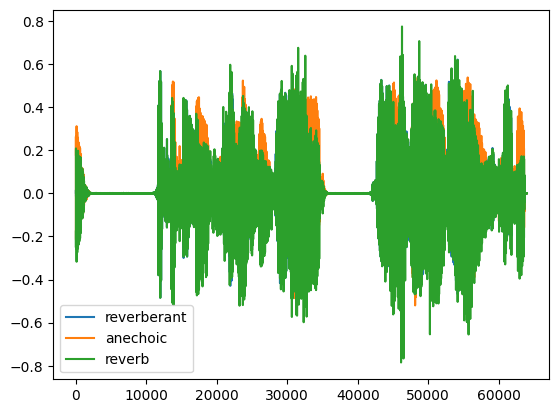

In [8]:
plt.plot(reverberant_src[0])
plt.plot(anechoic_src[0])
plt.plot(reverberant_src[0] - anechoic_src[0])
plt.legend(['reverberant', 'anechoic', 'reverb'])

Processed 0


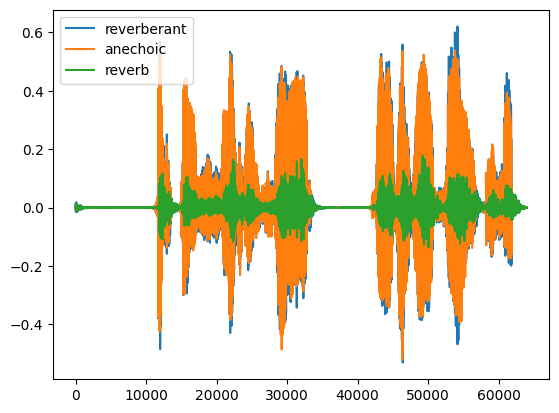

In [9]:
anechoic_src, reverberant_src = process(df.iloc[0], True)
plt.plot(reverberant_src[0])
plt.plot(anechoic_src[0])
plt.plot(reverberant_src[0] - anechoic_src[0])
plt.legend(['reverberant', 'anechoic', 'reverb'])


In [ ]:
Audio(mic_rirs, rate=16000)

In [ ]:
Audio(ane_rirs, rate=16000)

In [ ]:
np.max(np.abs(mic_rirs))

In [ ]:
np.max(np.abs(ane_rirs))

In [ ]:
np.max(np.abs(ane_rirs - mic_rirs))

In [ ]:
Audio(ane_rirs - mic_rirs, rate=16000)

In [ ]:
mic_rirs.shape

In [ ]:
processed_files = os.listdir(pjoin(pjoin(output_path, 'train'), 'reverberant'))

In [ ]:
processed_files = [os.path.splitext(x)[0]+'.flac' for x in processed_files]

In [ ]:
unprocessed_files = df[~df['speech_path'].isin(processed_files)]

In [ ]:
unprocessed_files[unprocessed_files['mls_split']=='test']

In [ ]:
unprocessed_files = unprocessed_files[unprocessed_files['mls_split']=='train']

In [ ]:
for i in tqdm.tqdm(range(len(unprocessed_files))):
    process(unprocessed_files.iloc[i])

In [ ]:
#KU100 DECODERS

In [ ]:
a = df.iloc[3]
hlp.plot_scene(np.array([a.room_x, a.room_y, a.room_z]), 
              np.array([a.headC_x, a.headC_y, a.headC_z]),
              np.array([a.headOrient_azi, a.headOrient_ele]),
              hlp.head_2_ku_ears(np.array([a.headC_x, a.headC_y, a.headC_z]),
              np.array([a.headOrient_azi, a.headOrient_ele])),
              np.array([[a.src_x, a.src_y, a.src_z]])) 



In [ ]:
decoder = mat73.loadmat('Ku100_Alfe_Window_Dense.mat')['hnm'] # weird
decoder = np.roll(decoder,500,axis=0)
#plt.plot(decoder[:,:,0])
Audio(process(a, False), rate=fs_target)

In [ ]:
decoder = mat73.loadmat('Ku100_Alfe_Window.mat')['hnm']
decoder = np.roll(decoder,500,axis=0)
#plt.plot(decoder[:,:,0])
Audio(process(a, False), rate=fs_target)

In [ ]:
decoder = mat73.loadmat('Ku100_noALFE_noWindow.mat')['hnm']
decoder = np.roll(decoder,500,axis=0)
#plt.plot(decoder[:,:,0])
Audio(process(a, False), rate=fs_target)

In [ ]:
decoder = mat73.loadmat('Ku100_ALFE_Window_sinEQ.mat')['hnm'] # weird
decoder = np.roll(decoder,500,axis=0)
#plt.plot(decoder[:,:,0])
Audio(process(a, False), rate=fs_target)

In [ ]:
decoder = mat73.loadmat('RIC_Alfe_Window_Dense.mat')['hnm'] # weird
decoder = np.roll(decoder,500,axis=0)
#plt.plot(decoder[:,:,0])
Audio(process(a, True), rate=fs_target)

In [ ]:
decoder = mat73.loadmat('RIC_Alfe_Window.mat')['hnm'] # weird
decoder = np.roll(decoder,500,axis=0)
#plt.plot(decoder[:,:,0])
Audio(process(a, True), rate=fs_target)

In [ ]:
decoder = mat73.loadmat('RIC_noALFE_noWindow.mat')['hnm'] # weird
decoder = np.roll(decoder,500,axis=0)
#plt.plot(decoder[:,:,0])
Audio(process(a, True), rate=fs_target)

In [ ]:
decoder = mat73.loadmat('RIC_Front_Omni_ALFE_Window_SinEQ.mat')['hnm'] # weird
decoder = np.roll(decoder,500,axis=0)
#plt.plot(decoder[:,:,0])
Audio(process(a, True), rate=fs_target)

In [ ]:
decoder = mat73.loadmat('RIC_Front_Omni_ALFE_Window_SinEQ.mat')['hnm'] # weird
decoder = np.roll(decoder,500,axis=0)
#plt.plot(decoder[:,:,0])
Audio(process(a, True), rate=fs_target)